In [ ]:
import pandas as pd


In [ ]:
dataset=pd.read_csv("housing.csv")

In [ ]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [ ]:
dataset["ocean_proximity"].value_counts()

ocean_proximity
<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: count, dtype: int64

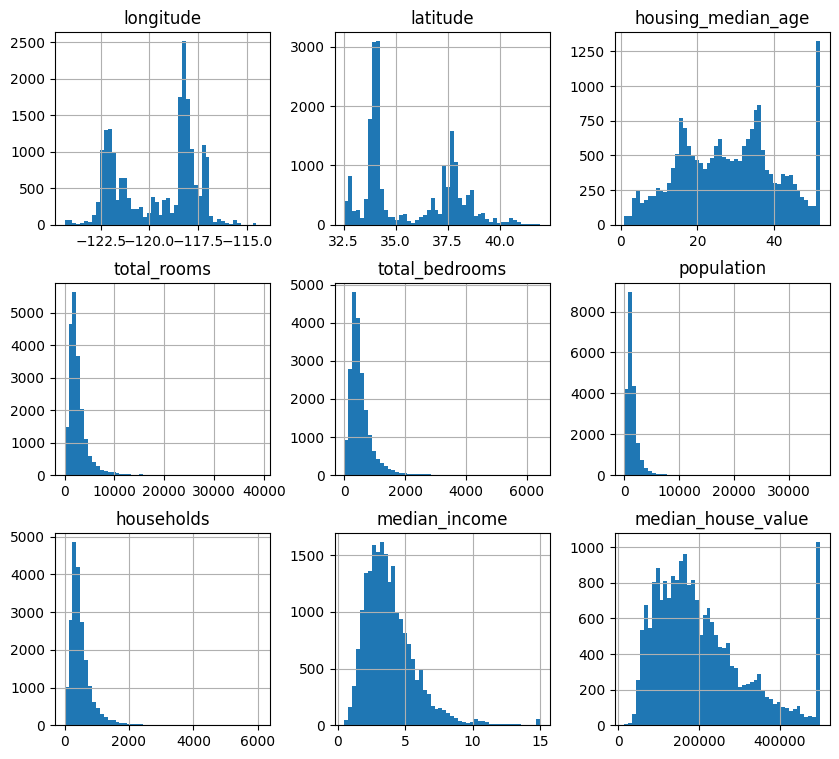

In [ ]:
import matplotlib.pyplot as plt
dataset.hist(bins=50, figsize=(10,9))
plt.show()

In [ ]:
import numpy as np
dataset["cat_income"]=pd.cut(dataset["median_income"], bins=[0,1.5,3.0,4.5,6.0,np.inf], labels=[1,2,3,4,5])

Text(0, 0.5, 'number of districts')

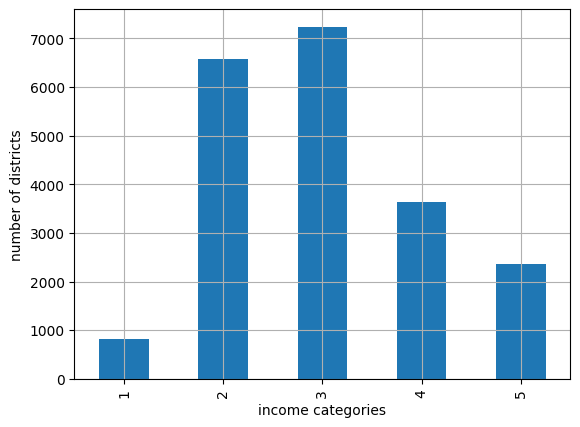

In [ ]:
dataset["cat_income"].value_counts().sort_index().plot.bar(grid=True)
plt.xlabel("income categories")
plt.ylabel("number of districts")

In [ ]:
from sklearn.model_selection import StratifiedShuffleSplit
splitter=StratifiedShuffleSplit(n_splits=10,test_size=0.2, random_state=42)
strat_split=[]
for train_idx,test_idx in splitter.split(dataset,dataset["cat_income"]):
  data_train=dataset.iloc[train_idx]
  data_test=dataset.iloc[test_idx]
  strat_split.append([data_train,data_test])



In [ ]:
strat_train_set,strat_test_set=strat_split[0]

In [ ]:
strat_train_set["cat_income"].value_counts()

cat_income
3    5789
2    5265
4    2911
5    1890
1     657
Name: count, dtype: int64

In [ ]:
for df in (strat_train_set,strat_test_set):
  df.drop("cat_income",axis=1,inplace=True)

<ipython-input-11-b539b0a19101>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop("cat_income",axis=1,inplace=True)
<ipython-input-11-b539b0a19101>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop("cat_income",axis=1,inplace=True)


In [ ]:
dataset=strat_train_set.copy()
dataset.info()

<class 'pandas.core.frame.DataFrame'>
Index: 16512 entries, 12655 to 19773
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           16512 non-null  float64
 1   latitude            16512 non-null  float64
 2   housing_median_age  16512 non-null  float64
 3   total_rooms         16512 non-null  float64
 4   total_bedrooms      16354 non-null  float64
 5   population          16512 non-null  float64
 6   households          16512 non-null  float64
 7   median_income       16512 non-null  float64
 8   median_house_value  16512 non-null  float64
 9   ocean_proximity     16512 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.4+ MB


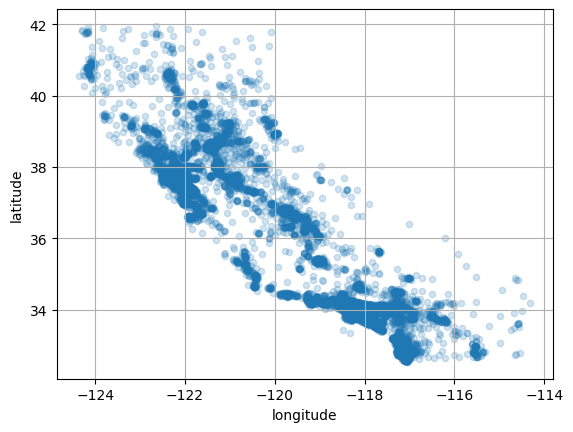

In [ ]:
dataset.plot(kind="scatter", x="longitude", y="latitude",alpha=0.2, grid=True)
plt.show()

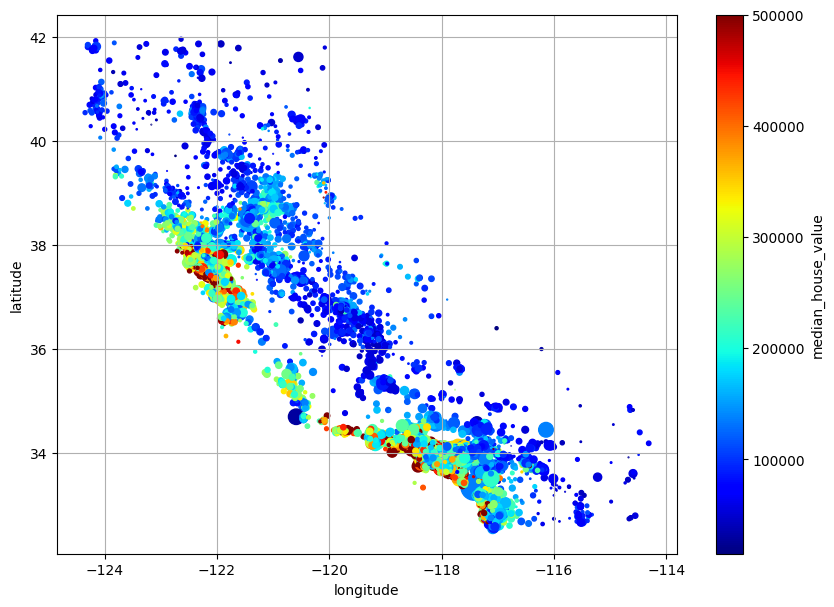

In [ ]:
dataset.plot(kind="scatter", x="longitude", y="latitude", s=dataset["population"]/100, c="median_house_value", cmap="jet",colorbar=True, legend=True, grid=True, figsize=(10,7))
plt.show()

In [ ]:
import numpy as np
numeric_columns=dataset.select_dtypes(include=[np.number])


<Axes: >

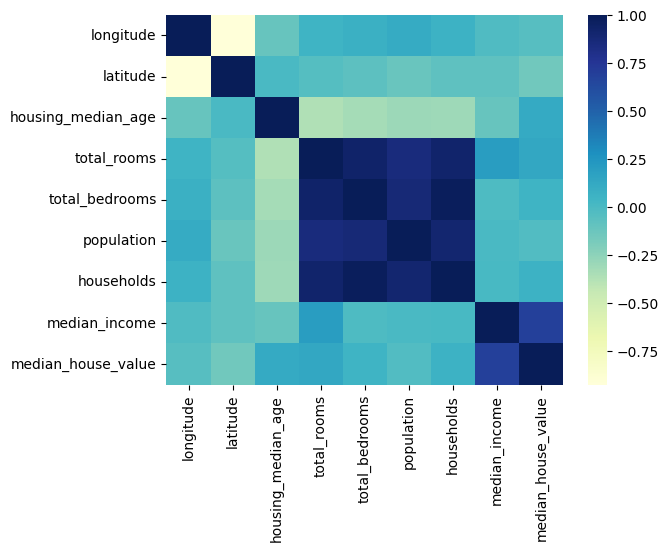

In [ ]:
import seaborn as sns
sns.heatmap(numeric_columns.corr(), cmap='YlGnBu')

In [ ]:
numeric_columns.corr()["median_house_value"].sort_values(ascending=False)

median_house_value    1.000000
median_income         0.687151
total_rooms           0.135140
housing_median_age    0.114146
households            0.064590
total_bedrooms        0.047781
population           -0.026882
longitude            -0.047466
latitude             -0.142673
Name: median_house_value, dtype: float64

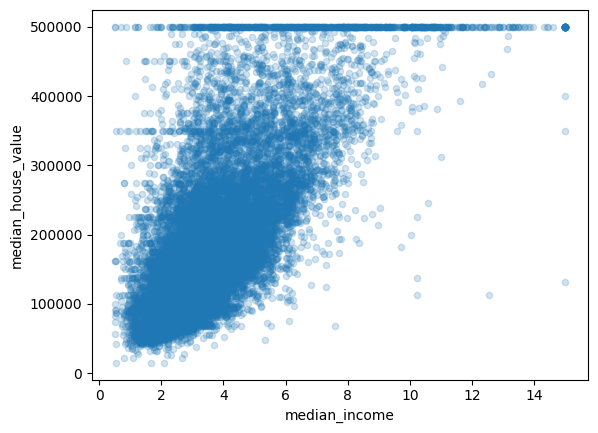

In [ ]:
# correlation values show that median_income is the most promising attribute in determining the median_house_value
dataset.plot(kind='scatter', x="median_income", y="median_house_value",alpha=0.2)
plt.show()


In [ ]:
dataset["rooms_per_house"]=dataset["total_rooms"]/dataset["population"]
dataset["bedrooms_ratio"]=dataset["total_bedrooms"]/dataset["total_rooms"]
dataset["people_per_house"]=dataset["population"]/dataset["population"]



In [ ]:
numeric_columns.corr()["median_house_value"].sort_values(ascending=False)

median_house_value    1.000000
median_income         0.687151
total_rooms           0.135140
housing_median_age    0.114146
households            0.064590
total_bedrooms        0.047781
population           -0.026882
longitude            -0.047466
latitude             -0.142673
Name: median_house_value, dtype: float64

In [ ]:
dataset=strat_train_set.drop(["median_house_value"], axis=1)
housing_labels=strat_train_set["median_house_value"].copy()


In [ ]:
numeric_cols=dataset.select_dtypes(include=[np.number])

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

num_pipeline= Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("minmax-sclaer",MinMaxScaler())
])
num_attr=list(numeric_cols)
cat_attr=["ocean_proximity"]
full_pipeline=ColumnTransformer([
    ("num", num_pipeline,num_attr),
    ("cat",OneHotEncoder(),cat_attr)
])
train_data=full_pipeline.fit_transform(dataset)

In [ ]:
from sklearn.ensemble import RandomForestRegressor
forest=RandomForestRegressor()
forest.fit(train_data,housing_labels)

RandomForestRegressor()

In [ ]:
print("Predictions:", forest.predict(train_data))
print("Labels:", list(housing_labels))

Predictions: [ 74487.   303202.03  79727.   ... 161722.   236687.    75685.  ]
Labels: [72100.0, 279600.0, 82700.0, 112500.0, 238300.0, 165700.0, 412300.0, 349600.0, 181300.0, 500001.0, 57500.0, 350000.0, 238800.0, 80300.0, 200400.0, 333700.0, 158000.0, 276800.0, 327200.0, 194500.0, 163100.0, 331200.0, 92000.0, 153400.0, 139100.0, 85900.0, 238100.0, 173500.0, 196100.0, 442900.0, 234600.0, 195400.0, 264100.0, 415800.0, 282300.0, 345200.0, 85000.0, 279400.0, 95700.0, 191800.0, 225400.0, 163500.0, 150300.0, 217100.0, 157500.0, 163200.0, 105100.0, 213700.0, 98200.0, 235300.0, 182400.0, 390800.0, 179900.0, 46700.0, 339800.0, 151400.0, 105000.0, 183300.0, 125700.0, 123600.0, 249400.0, 152600.0, 293300.0, 116700.0, 133000.0, 261900.0, 87500.0, 126500.0, 261600.0, 225800.0, 196500.0, 109800.0, 174400.0, 217700.0, 172400.0, 325000.0, 132200.0, 184800.0, 163700.0, 142500.0, 50000.0, 307400.0, 253700.0, 340400.0, 72300.0, 121800.0, 85000.0, 148200.0, 118800.0, 263100.0, 344200.0, 315600.0, 156000

In [ ]:
from sklearn.metrics import mean_squared_error
predictions=forest.predict(train_data)
mse=mean_squared_error(predictions,housing_labels)
rmse=np.sqrt(mse)
rmse

18426.203649791598

In [ ]:
from sklearn.model_selection import GridSearchCV
model = RandomForestRegressor()
param_grid = [
    {'n_estimators': [3, 10, 30], 'max_features': [2, 4, 6, 8]},
    {'bootstrap': [False], 'n_estimators': [3, 10], 'max_features': [2, 3, 4]},
]
grid_search=GridSearchCV(model,param_grid,cv=5, n_jobs=-1,verbose=2)
grid_search.fit(train_data,housing_labels)

Fitting 5 folds for each of 18 candidates, totalling 90 fits


GridSearchCV(cv=5, estimator=RandomForestRegressor(), n_jobs=-1,
             param_grid=[{'max_features': [2, 4, 6, 8],
                          'n_estimators': [3, 10, 30]},
                         {'bootstrap': [False], 'max_features': [2, 3, 4],
                          'n_estimators': [3, 10]}],
             verbose=2)

In [ ]:
grid_search.best_params_

{'max_features': 6, 'n_estimators': 30}

In [ ]:
final_model=grid_search.best_estimator_
x_test=strat_test_set.drop("median_house_value",axis=1)
y_test=strat_test_set["median_house_value"].copy()
final_x_test=full_pipeline.transform(x_test)
final_predictions=final_model.predict(final_x_test)
mse=mean_squared_error(final_predictions,y_test)
rmse=np.sqrt(mse)


In [ ]:
rmse

47384.52044342121